To select the optimal value of k using the training and testing curves, you can consider a few approaches. Here are two common methods:

1. Elbow Method:
   - Plot the training and testing curves as described in the previous response.
   - Look for the point on the plot where the testing curve reaches its highest point and starts to plateau.
   - The optimal value of k is typically selected at the elbow point, which represents a good balance between model complexity and generalization.
   - The elbow point is often characterized by a significant increase in the training curve while the testing curve starts to level off or show diminishing returns.
   - Choose the value of k at the elbow point as the optimal value.

2. Grid Search:
   - Instead of visually inspecting the plot, you can perform a systematic search for the optimal value of k using a grid search approach.
   - Define a range of values for k that you want to consider.
   - Train and evaluate the model for each value of k using cross-validation or a separate validation set.
   - Calculate the average performance metric (e.g., accuracy) for each value of k based on the training and testing results.
   - Select the value of k that maximizes the performance metric on the testing set as the optimal value.

Remember, the choice of the optimal value of k depends on the specific problem and dataset. It's essential to strike a balance between model complexity and generalization by avoiding both underfitting and overfitting. Experiment with different values of k and evaluate their performance using appropriate evaluation metrics to make an informed decision.

In [1]:
from warnings import simplefilter

# Import the `simplefilter` function from the `warnings` module.

# This function allows us to control the behavior of future warnings.

# Ignore all future warnings

simplefilter(action='ignore', category=FutureWarning)

# The `action='ignore'` parameter specifies that any future warnings should be ignored.

# The `category=FutureWarning` parameter indicates that the filter should apply specifically to future warnings.

# This code is useful when you want to suppress any warnings that might be raised in your program,particularly future warnings that could result from changes or updates to the libraries or modules you're using.


In [2]:
# importing libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import math

In [3]:
# Generate a synthetic classification dataset

# The `make_classification` function from the `sklearn.datasets` module is used to create a synthetic classification dataset.
# It generates random samples with specified characteristics.

# n_samples: The total number of samples in the dataset. In this case, 1000 samples will be generated.
# n_features: The number of features (or input variables) in the dataset. Here, 2 features will be generated.
# n_informative: The number of informative features, which are the features that actually contribute to the classification task. In this case, 2 informative features will be generated.
# n_redundant: The number of redundant features, which are linear combinations of informative features. Here, no redundant features will be generated.
# n_clusters_per_class: The number of clusters per class. This parameter controls the separation between classes. In this case, there will be 1 cluster per class, resulting in well-separated classes.
# random_state: The random seed used for reproducibility. The value 60 is chosen as the random state.

x, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=60)

# Split the dataset into training and testing sets

# The `train_test_split` function from the `sklearn.model_selection` module is used to split the dataset into training and testing sets.
# It randomly shuffles and partitions the data into separate subsets.

# X_train: The training feature set.
# X_test: The testing feature set.
# y_train: The training labels.
# y_test: The testing labels.

# x: The input features of the dataset.
# y: The target variable (class labels) of the dataset.
# stratify: This parameter ensures that the class distribution is preserved in the train-test split. Each class will have the same proportion in both training and testing sets.
# random_state: The random seed used for reproducibility. The value 42 is chosen as the random state.

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)


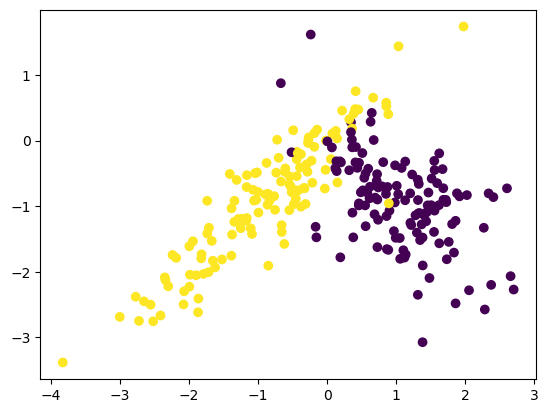

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Enable inline plotting within Jupyter Notebook or JupyterLab.

colors = {0: 'red', 1: 'blue'}

# Create a dictionary to map class labels to colors.

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

# Create a scatter plot of the testing feature set.

# X_test[:, 0]: The values of the first feature in the testing set.
# X_test[:, 1]: The values of the second feature in the testing set.
# c=y_test: The color assignment for each data point based on the corresponding class label (0 or 1).

plt.show()

# Display the scatter plot.


In [5]:
def give_group_list(folds_range, length):
    """
    Generate a list of indices for cross-validation and training sets.

    Parameters:
    - folds_range (list): A list of tuples specifying the range of indices for each fold.
    - length (int): The total length of the dataset.

    Returns:
    - full_list (list): A list of sublists, where each sublist contains the indices for cross-validation and training sets.

    """

    full_list = []

    # Iterate over each fold range
    for f in folds_range:
        # Create a set of all indices from 0 to length-1
        full = set(range(0, length))

        # Create a set of indices for cross-validation
        cv_index = set(range(f[0], f[1] + 1))

        # Calculate the complement set for training indices
        train_index = full - cv_index

        # Append the cross-validation and training indices as a sublist to full_list
        full_list.append([list(cv_index), list(train_index)])

    return full_list


In [6]:
def k_fold_index(fold, length):
    """
    Generate a list of fold ranges for k-fold cross-validation.

    Parameters:
    - fold (int): The number of folds for cross-validation.
    - length (int): The total length of the dataset.

    Returns:
    - lst (list): A list of tuples specifying the range of indices for each fold.

    """

    step = length // fold
    pre = 0
    lst = []

    # Generate the fold ranges
    for i in range(0, length, step):
        if i == 0:
            continue
        lst.append([pre, (i - 1)])
        pre = i

    # Check if there are remaining elements
    if length - pre > 0:
        if len(lst) != fold:
            lst.append([pre, (length - 1)])
        else:
            lst[-1][1] = length - 1

    return lst


In [7]:
def random_distributed_10_value(r):
    """
    Generate a list of 10 randomly distributed values within a given range.

    Parameters:
    - r (list): A list containing the start and end values of the range.

    Returns:
    - curr_list (list): A list of 10 randomly distributed values within the given range.

    """

    curr_list = []

    # Create a list of odd numbers within the given range
    mylist = list(filter(lambda x: x % 2 != 0, list(range(r[0], r[1]))))

    # Calculate the length and steps
    length = len(mylist)
    steps = length // 10

    # Generate the 10 randomly distributed values
    for i in range(0, length, steps):
        curr_list.append(mylist[i])

    return curr_list[:10]


In [8]:
def ecud_with_sorting_with_class_label(x, y_lab, y):
    """
    Calculate Euclidean distances between a data point and a set of points and sort the results with class labels.

    Parameters:
    - x (list): The data point for which the distances are calculated.
    - y_lab (list): The list of class labels corresponding to the data points.
    - y (list): The set of data points for which the distances are calculated.

    Returns:
    - lst (list): A list of tuples containing the sorted Euclidean distances and their corresponding class labels.

    """

    lst = []

    # Iterate over each data point
    for j in range(len(x)):
        sum = 0

        # Calculate the Euclidean distance for each data point
        for i in range(len(y)):
            sum += pow((x[j][i] - y[i]), 2)

        # Append the Euclidean distance and its corresponding class label as a tuple to lst
        lst.append((math.sqrt(sum), y_lab[j]))

        # Sort the list by the Euclidean distances
        lst.sort()

    return lst


In [9]:
def predict(x_tr, y_tr, que, k):
    """
    Predict the labels for a set of query points using k-nearest neighbors algorithm.

    Parameters:
    - x_tr (list): The training data points.
    - y_tr (list): The class labels corresponding to the training data points.
    - que (list): The query points for which the labels are predicted.
    - k (int): The number of nearest neighbors to consider.

    Returns:
    - lst (list): A list of predicted labels for the query points.

    """

    lst = []

    # Iterate over each query point
    for j in que:
        # Calculate the distances and sort with class labels for the query point
        curr_dis = ecud_with_sorting_with_class_label(x_tr, y_tr, j)

        lable_0 = 0
        # Count the number of class label 0 among the k nearest neighbors
        for i in range(k):
            if curr_dis[i][1] == 0:
                lable_0 += 1

        # Predict the label based on the majority of class labels among the k nearest neighbors
        if lable_0 > k // 2:
            lst.append(0)
        else:
            lst.append(1)

    return lst


In [10]:
def accu_score(y_t, y_p):
    """
    Calculate the accuracy score between the true labels and predicted labels.

    Parameters:
    - y_t (list): The true labels.
    - y_p (list): The predicted labels.

    Returns:
    - score (float): The accuracy score between the true labels and predicted labels.

    """

    total = 0

    # Iterate over each element in the true labels
    for i in range(len(y_t)):
        # Check if the true label matches the predicted label
        if y_t[i] == y_p[i]:
            total += 1

    # Calculate and return the accuracy score
    score = total / len(y_t)
    return score


In [11]:
def RandomSearchCV(x_train, y_train, param_range, folds):
    """
    Perform Randomized Search Cross-Validation for selecting hyperparameters.

    Parameters:
    - x_train (list): The training data.
    - y_train (list): The class labels corresponding to the training data.
    - param_range (list): The range of hyperparameters to be searched.
    - folds (int): The number of folds for cross-validation.

    Returns:
    - trainscores (list): A list of mean training scores for each hyperparameter value.
    - testscores (list): A list of mean testing scores for each hyperparameter value.

    """

    # Generate random hyperparameters from the given range
    params = random_distributed_10_value(param_range)

    # Generate the fold ranges for cross-validation
    folds_range = k_fold_index(folds, len(x_train))

    trainscores = []
    testscores = []

    # Iterate over each hyperparameter value
    for k in tqdm(params):
        trainscores_folds = []
        testscores_folds = []

        # Iterate over each fold
        for j in give_group_list(folds_range, len(x_train)):

            # Select the data points based on the train_indices and test_indices
            X_train = x_train[j[1]]
            Y_train = y_train[j[1]]
            X_test = x_train[j[0]]
            Y_test = y_train[j[0]]

            # Predict the labels for the test data using the selected hyperparameter value
            Y_predicted = predict(X_train, Y_train, X_test, k)
            testscores_folds.append(accu_score(Y_test, Y_predicted))

            # Predict the labels for the training data using the selected hyperparameter value
            Y_predicted = predict(X_train, Y_train, X_train, k)
            trainscores_folds.append(accu_score(Y_train, Y_predicted))

        # Calculate the mean training and testing scores for the current hyperparameter value
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))

    return trainscores, testscores


In [12]:
t_s,te_s = RandomSearchCV(X_train, y_train,(1,50),3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.38s/it]


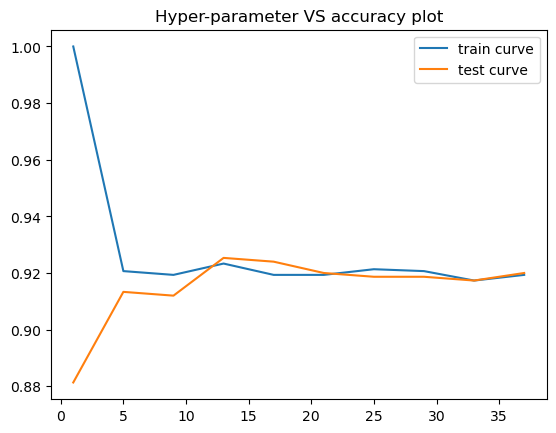

In [13]:
param_ranges = random_distributed_10_value((1, 50))

# Plotting the training and testing curves
plt.plot(param_ranges, t_s, label='train curve')
plt.plot(param_ranges, te_s, label='test curve')

# Adding a title and legend to the plot
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()

# Display the plot
plt.show()
